# The Emergence of Political Actors in Two Dimensions
An extension of the classic model from Robert Axelrod from one to two dimensions

* Robert Axelrod, "The Complexity of Cooperation", Princeton University Press, 1997 (Chapter 6 "Building New Political Actors")
* Robert Axelrod, "A Model of the Emergence of New Political Actors" 
in Artificial Societies: The Computer Simulation of Social Life, ed. Nigel Gilbert and Rosaria
Conte (London: University College Press, 1995), 19–39.
* Lars-Erik Cederman, "Emergent Actors in World Politics", Princeton University Press, 1997

### The libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import logging

### The agents

In [2]:
HARVEST = 1
TRIBUTE = 250
TAX_RATE = 1/10
WAR_COST = 1/4
NUMBER_OF_WARS = 33

class Agent: 
  def __init__(self, name, wealth):
    self.name = name                    # name of the actor (can be A, B, C or ID like 1,2,3)
    self.wealth = wealth                # wealth of the actor, initially between 300 and 500
    self.x = 0                          # horizontal location in landscape
    self.y = 0                          # vertical location in landscape
    self.king = None                    # actor to pay tribute to
    self.alliance = []                  # allied actors
    self.opponents = []                 # enemy actors

  def harvest(self, amount=HARVEST):
    self.wealth = self.wealth + amount  # annual harvest
    
  def description(self):
    names = [agent.name for agent in list(set(self.alliance+[self]))]
    return ' '.join(names)
    
  def total_wealth(self):
    if len(self.alliance) > 0:
      result = sum([agent.wealth for agent in self.alliance])
    else:
      result = self.wealth
    return round(result)

  def subtract_total_wealth(self, amount):    
    if len(self.alliance) > 0:
      members = len(self.alliance)+1
      self.subtract_wealth(amount/members)
      for agent in self.alliance:
        agent.subtract_wealth(amount/members)
    else:
      self.subtract_wealth(amount)

  def add_total_wealth(self, amount):    
    if len(self.alliance) > 0:
      members = len(self.alliance)+1
      self.add_wealth(amount/members)
      for agent in self.alliance:
        agent.add_wealth(amount/members)
    else:
      self.add_wealth(amount)
    
  def subtract_wealth(self, amount):
    self.wealth = self.wealth - amount
    if self.wealth < 0: self.wealth = 0

  def add_wealth(self, amount):
    self.wealth = self.wealth + amount

  def vulnerability(self, attacker):
    if attacker.total_wealth() == 0:
      return 0
    else:
      return (attacker.total_wealth() - self.total_wealth())/attacker.total_wealth();

  def possible_tribute(self):
    return min(TRIBUTE, self.total_wealth())

  def select_target(self, targets):
    incentives = [target.vulnerability(self)*target.possible_tribute() for target in targets]
    if len(incentives) > 0:
      return targets[incentives.index(max(incentives))]
    else:
      return None

  def select_strategy(self, opponent):
    cost_fight = round(opponent.wealth*WAR_COST)
    cost_pay = self.possible_tribute()
    if cost_fight > cost_pay:
      strategy = "PAY"
    else:
      strategy = "FIGHT"
    return strategy

  def interact(self, opponent):
    strategy = opponent.select_strategy(self)
    # print("Agent", self.name, "demands tribute from agent", opponent.name, "who picks", strategy)
    if strategy == "FIGHT":
      opponent.subtract_total_wealth(round(self.total_wealth()*WAR_COST))
      self.subtract_total_wealth(round(opponent.total_wealth()*WAR_COST))
      opponent.king = None
    if strategy == "PAY":
      tribute = opponent.possible_tribute()
      opponent.subtract_wealth(tribute)
      self.add_wealth(tribute)
      opponent.king = self
    return strategy

Check if they work as expected

In [3]:
a = Agent("A", 50)
b = Agent("B", 100)
c = Agent("C", 350)
d = Agent("D", 500)
print("Agent A wealth", a.wealth)
print("Agent B wealth", b.wealth)
print("Agent B vulnerability for A", a.vulnerability(b))
print("Agent A vulnerability for B", b.vulnerability(a))
print("Agent A strategy for B", a.select_strategy(b))
print("Agent B strategy for A", b.select_strategy(a))
b.interact(a)
print("Agent A wealth", a.wealth)
print("Agent B wealth", b.wealth)
target = d.select_target([a,b,c])
print(f"Agent {d.name} selects target agent {target.name}")

Agent A wealth 50
Agent B wealth 100
Agent B vulnerability for A 0.5
Agent A vulnerability for B -1.0
Agent A strategy for B FIGHT
Agent B strategy for A FIGHT
Agent A wealth 25
Agent B wealth 94
Agent D selects target agent B


### The agent based model

In [4]:
class AgentBasedModel:
  def __init__(self, size, rate = 0):
    self.grid_size = size
    self.agents = 0
    self.grid = np.empty(size ** 2, dtype=object).reshape((size, size))
    self.commitment = np.zeros(size ** 4, dtype=float).reshape((size ** 2, size ** 2))
    self.data = []
    self.timestep = 0
    
    for x in range(size):
      for y in range(size):
        agent = self.new_random_agent()
        self.add_agent_to_grid(agent, x, y)
        
  def new_random_agent(self, wealth = None):
    if not wealth: wealth = random.randint(300, 500)
    self.agents = self.agents + 1
    return Agent(str(self.agents), wealth)

  def new_random_position(self):
    i = random.randrange(0, self.agents)
    return (i // self.grid_size), (i % self.grid_size)
        
  def add_agent_to_grid(self, agent, x, y):
    agent.x = x
    agent.y = y
    self.grid[y, x] = agent
        
  def grid_position(self, x, y):
    if x >= self.grid_size: x = 0
    if y >= self.grid_size: y = 0
    if x < 0: x = self.grid_size-1
    if y < 0: y = self.grid_size-1
    return x, y

  def neighborhood(self, x, y):
    # Von Neumann neighborhood
    top    = self.grid_position(x, y-1)
    right  = self.grid_position(x+1, y)
    left   = self.grid_position(x-1, y)
    bottom = self.grid_position(x, y+1)
    return [top, right, left, bottom]

  def number(self, agent):
    # works because agents are named by their number of creation
    return int(agent.name)-1

  def friendship(self, agent1, agent2):
    return self.commitment[self.number(agent1), self.number(agent2)]

  def get_allies(self, agent, opponent):
    alliance, opponents = self.get_alliance(agent, agent, [], [])
    return [actor for actor in alliance if self.friendship(actor, agent) > self.friendship(actor, opponent)]

  def get_alliance(self, demander, agent, alliance, opponents):
    # get list of all agents in neighborhood which are allies and have a mutual commitment.
    # the boundary of this cluster is the number of possible opponents.
    neighbors = [self.grid[y,x] for x,y in self.neighborhood(agent.x, agent.y)] 
    allies = [neighbor for neighbor in neighbors if self.friendship(demander, neighbor) > 0]
    enemies = [neighbor for neighbor in neighbors if self.friendship(demander, neighbor) <= 0]            
    new_allies = list(set(allies) - set(alliance + [demander]))
    new_enemies = list(set(enemies) - set(opponents + [demander]))
    alliance = alliance + new_allies
    opponents = opponents + new_enemies               
    if len(new_allies) > 0:
      for neighbor in new_allies:
        allies, enemies = self.get_alliance(demander, neighbor, alliance, opponents)
        alliance = alliance + allies
        opponents = opponents + enemies  
    return list(set(alliance)), list(set(opponents))

  def change_commitments(self, agent, opponent, strategy):
    self.change_commitment(agent, opponent, strategy)
    if strategy == "FIGHT":
      for friend in agent.alliance:
        self.change_commitment(agent, friend, "COMMON_FIGHT")
      for enemy in opponent.alliance:
        self.change_commitment(opponent, enemy, "COMMON FIGHT")
        self.change_commitment(agent, enemy, "FIGHT")        
                       
  def change_commitment(self, agent, opponent, strategy):
    logging.info(f"Creating commitment between {agent.name} and {opponent.name}")
    logging.info(f"Commitment before {self.friendship(agent, opponent)}")
    if strategy == "FIGHT":
      value = self.commitment[self.number(agent), self.number(opponent)]
      value = max(0, value - 0.1)
      logging.info(f"New commitment {value}")
      self.commitment[self.number(agent), self.number(opponent)] = value
      self.commitment[self.number(opponent), self.number(agent)] = value    
    
    if strategy in ["PAY", "COMMON_FIGHT"]:
      value = self.commitment[self.number(agent), self.number(opponent)]
      value = min(1, value + 0.1)
      logging.info(f"New commitment {value}")
      self.commitment[self.number(agent), self.number(opponent)] = value
      self.commitment[self.number(opponent), self.number(agent)] = value
    
    logging.info(f"Commitment after {self.friendship(agent, opponent)}")
        
        
  def update_alliances(self):    
    for agent in self.grid.flatten():
      agent.alliance, agent.opponents = self.get_alliance(agent, agent, [], [])
      
  def harvest(self):
    for agent in self.grid.flatten():
      agent.harvest()

  def collect_tribute(self):
    for agent in self.grid.flatten():
      if agent.king:
        tribute = min(HARVEST * TAX_RATE, agent.wealth)
        agent.subtract_wealth(tribute)
        agent.king.add_wealth(tribute)
    
  def interaction(self): 
    self.update_alliances()
    self.harvest()
    self.collect_tribute()
    for i in range(NUMBER_OF_WARS):
      while True:
        x,y = self.new_random_position()
        agent = self.grid[x,y]
        if agent and not agent.king:
          break
                
      opponent_names = ", ".join([actor.name for actor in agent.opponents])
      logging.info(f"Agent {agent.description()} is selecting an opponent from {opponent_names}")
      opponent = agent.select_target(agent.opponents)
      if opponent:
        agent.alliance = self.get_allies(agent, opponent)
        opponent.alliance = self.get_allies(opponent, agent)
        logging.info(f"Agent {agent.name} is demanding tribute from agent {agent.name}")
        logging.info(f"Agent {agent.name} belongs to group {agent.description()}, total wealth is {agent.total_wealth()}")
        logging.info(f"Agent {opponent.name} belongs to group {opponent.description()}, total wealth is {opponent.total_wealth()}")
        strategy = agent.interact(opponent)
        logging.info(f"Oponent {opponent.name} selects {strategy}")
        logging.info(f"Agent {agent.name} total wealth is {agent.total_wealth()}")
        logging.info(f"Agent {opponent.name} total wealth is {opponent.total_wealth()}")
        self.change_commitments(agent, opponent, strategy)

  def count_class(self, min_wealth, max_wealth):
    count = 0
    all_agents = list(self.grid.flatten())
    for agent in all_agents:
      if (agent.wealth >= min_wealth) and (agent.wealth <= max_wealth):
        count += 1
    if len(all_agents) == 0: return 0
    return count / len(all_agents)

  def count_colonies(self):
    count = 0
    all_agents = list(self.grid.flatten())
    for agent in all_agents:
      if (agent.king):
        count += 1
    if len(all_agents) == 0: return 0
    return count / len(all_agents)

  def play(self, timestep):
    self.interaction()

  def record_statistics(self, timestep):
    super_rich = self.count_class(450, 10000) 
    wealthy = self.count_class(400, 450) 
    middle = self.count_class(350, 400)    
    poor = self.count_class(0, 350)  
    colonies = self.count_colonies()
    kings = 1-self.count_colonies()
    self.data.append([timestep, super_rich * 100, wealthy * 100, middle * 100, poor * 100, colonies * 100, kings * 100])
    
  def wealth_grid(self):
    agents = self.grid.flatten()
    wealth_distribution = np.array([agent.wealth if agent else 0 for agent in agents])
    return wealth_distribution.reshape((self.grid_size, self.grid_size))

  def coalition_grid(self):
    result = np.zeros(self.grid_size ** 2, dtype=int).reshape((self.grid_size, self.grid_size))
    coalition_sizes = [[len(agent.alliance), agent] for agent in self.grid.flatten()]
    coalition_sizes.sort(key=lambda x: x[0], reverse=True)
    if coalition_sizes:
      i = 0
      for coalition in coalition_sizes[:5]:
        logging.info(f"coalition {i+1} for agent {coalition[1].name} which has {coalition[0]} allies")
        i += 1
        alliance = coalition[1].alliance+[coalition[1]]
        for agent in alliance:
          result[agent.x, agent.y] = len(alliance)
    return result

  def stats(self):
    result = [[agent.name, agent.wealth, len(agent.alliance), agent.description()] for agent in self.grid.flatten()]
    result.sort(key=lambda x: -x[1])    
    return result    
    
  def run(self, timesteps):
    for t in range(self.timestep, self.timestep+timesteps):
      logging.info(f"***** new timestep {t} *****")   
      self.play(t)
      self.record_statistics(t)
    self.timestep += timesteps

### Simulation Results

Run the model for a grid of 10 * 10 agents

In [5]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] : %(message)s',
                    filename='simulation.log',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filemode="w",
                    level=logging.INFO)
logging.info('Started')

In [6]:
GRID_SIZE = 10
TIME_STEPS = 25
logging.info(f"Generated Agent-Based model for {GRID_SIZE}x{GRID_SIZE} agents")
model = AgentBasedModel(GRID_SIZE)

grid_time_0 = model.wealth_grid()
coalition_grid_time_0 = model.coalition_grid()

logging.info(f"Running {TIME_STEPS} timesteps")
model.run(TIME_STEPS)
grid_time_1 = model.wealth_grid()
coalition_grid_time_1 = model.coalition_grid()

logging.info(f"Running {TIME_STEPS} timesteps")
model.run(TIME_STEPS)
grid_time_2 = model.wealth_grid()
coalition_grid_time_2 = model.coalition_grid()

logging.info(f"Running {TIME_STEPS} timesteps")
model.run(TIME_STEPS)
grid_time_3 = model.wealth_grid()
coalition_grid_time_3 = model.coalition_grid()

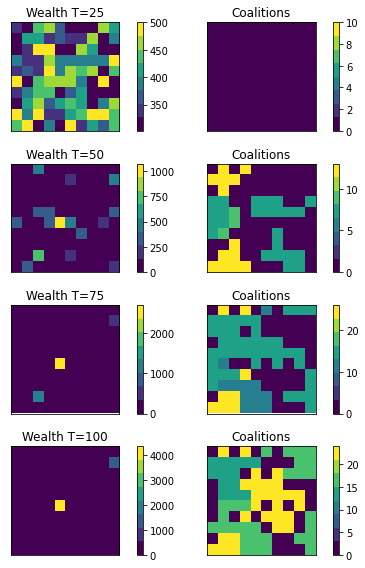

In [7]:
%matplotlib inline

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))
fig.set_tight_layout(True)

colormap = plt.get_cmap('viridis', 8)
cmap1 = mpl.colors.ListedColormap(colormap.colors)

img1 = ax[0,0].matshow(grid_time_0, cmap=cmap1)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title(f"Wealth T={TIME_STEPS*1}")
fig.colorbar(img1, ax=ax[0,0])

img2 = ax[0,1].matshow(coalition_grid_time_0, cmap=cmap1, vmin=0, vmax=10)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title("Coalitions")
fig.colorbar(img2, ax=ax[0,1])

img3 = ax[1,0].matshow(grid_time_1, cmap=cmap1)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title(f"Wealth T={TIME_STEPS*2}")
fig.colorbar(img3, ax=ax[1,0])

img4 = ax[1,1].matshow(coalition_grid_time_1, cmap=cmap1)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title("Coalitions")
fig.colorbar(img4, ax=ax[1,1])

img5 = ax[2,0].matshow(grid_time_2, cmap=cmap1)
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_title(f"Wealth T={TIME_STEPS*3}")
fig.colorbar(img5, ax=ax[2,0])

img6 = ax[2,1].matshow(coalition_grid_time_2, cmap=cmap1)
ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].set_title("Coalitions")
fig.colorbar(img6, ax=ax[2,1])

img7 = ax[3,0].matshow(grid_time_3, cmap=cmap1)
ax[3,0].set_xticks([])
ax[3,0].set_yticks([])
ax[3,0].set_title(f"Wealth T={TIME_STEPS*4}")
fig.colorbar(img7, ax=ax[3,0])

img8 = ax[3,1].matshow(coalition_grid_time_3, cmap=cmap1)
ax[3,1].set_xticks([])
ax[3,1].set_yticks([])
ax[3,1].set_title("Coalitions")
fig.colorbar(img8, ax=ax[3,1])

plt.savefig("PoliticalActorsCoalition.png", format="png")

In [8]:
df = pd.DataFrame(model.stats(), columns=['Name', 'Wealth', 'Alliances', 'Allies'])
df.head(50)

,Name,Wealth,Alliances,Allies
0,46,4349.233333,23,36 25 46 37 49 57 55 19 20 48 27 28 59 34 47 3...
1,92,1114.684656,23,2 73 11 90 12 8 74 80 13 64 100 91 82 21 85 94...
2,67,262.375000,10,71 70 69 87 61 66 78 77 67 79 68
3,35,243.833333,3,46 34 45 35
4,95,137.238095,14,62 86 85 54 53 94 73 84 75 96 72 6 52 74 95
5,29,77.927381,16,71 70 80 20 73 30 8 19 89 100 9 10 28 11 90 29 21
6,91,55.384656,1,92 91
7,82,54.484656,1,82 92
8,93,52.684656,1,92 93
9,94,48.151323,6,85 94 83 84 96 6 95


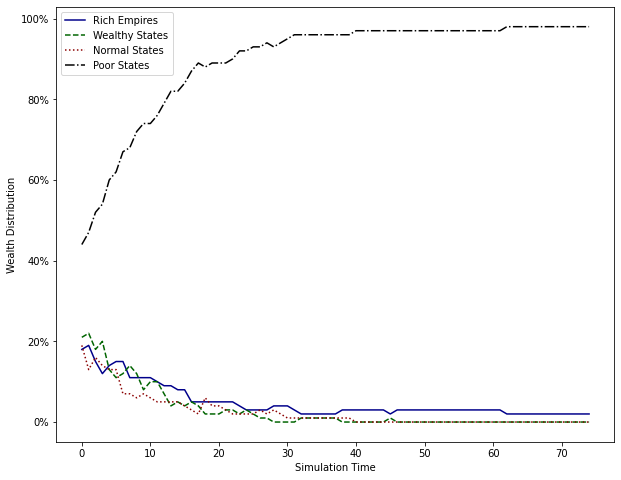

In [9]:
%matplotlib inline
df = pd.DataFrame(model.data, columns=['Time', 'SuperRich', 'Wealthy', 'Middle', 'Poor', 'Colonies', 'Kings'])
fig, ax = plt.subplots(figsize=(10, 8))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Wealth Distribution")
plt.xlabel("Simulation Time")
plt.plot(df.Time, df.SuperRich, color="DarkBlue", label='Rich Empires', linestyle='solid')
plt.plot(df.Time, df.Wealthy, color="DarkGreen", label='Wealthy States', linestyle='dashed')
plt.plot(df.Time, df.Middle, color="DarkRed", label='Normal States', linestyle='dotted') 
plt.plot(df.Time, df.Poor, color="Black", label='Poor States', linestyle='dashdot')
plt.legend()
plt.savefig("PoliticalActorsWealth.png", format="png")
plt.show()

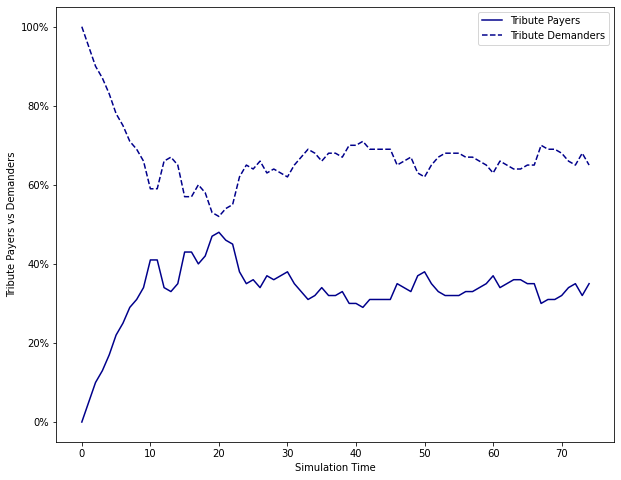

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Tribute Payers vs Demanders")
plt.xlabel("Simulation Time")
plt.plot(df.Time, df.Colonies, color="DarkBlue", label='Tribute Payers', linestyle='solid')
plt.plot(df.Time, df.Kings, color="DarkBlue", label='Tribute Demanders', linestyle='dashed')
plt.legend()
plt.savefig("PoliticalActorsKings.png", format="png")
plt.show()